# Imports

In [3]:
# User-defined functions!
# All data preparation functions for GDP data and explanatory variables
from Functions.data_prep import data_GDP, data_explanatory
# imports for Moran's I analysis and plotting graphs
from Functions.spatial_functions import spatial_weight_matrix, neighborhood_dict_creation, global_moran_val, local_moran_val,lisa_df_update, local_moran_density_plot, local_moran_plots, lisa_cluster_map
# Spatial outlier analysis
from Functions.Spatial_outlier_analysis import explanatory_HL_LH_df_creation, create_interactive_bar_graph, create_categorical_heatmap_HL, country_code_analysis, create_heatmap

# All required imports
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import random

random.seed(120)

# Spatial Autocorrelation Analysis

## Data preparation & Spatial Weights Creation

In [4]:
# Data preparation and cleaning for GDP data
# Setting time_period option to average over all years since this is spatial analysis and time is aggregated
time_period_option = 'average_all_years'
gdf_lvl = data_GDP(3, time_period_option)
# Setting index to NUTS_ID before you create the spatial weights (so neighborhood dictionary has NUTS ID values)
gdf_lvl.set_index('NUTS_ID', inplace=True)
w_adaptive = spatial_weight_matrix(gdf_lvl, 15)
neighbor_weights_dict = neighborhood_dict_creation(w_adaptive)

### Global and Local Moran's I

In [5]:
global_moran = global_moran_val(gdf_lvl, 'GDP_VALUE', w_adaptive)
lisa = local_moran_val(gdf_lvl, 'GDP_VALUE', w_adaptive)

In [6]:
print("Global Moran's I value: "+str(global_moran.I))
print("p-value: "+str(global_moran.p_sim))

Global Moran's I value: 0.5594428103725201
p-value: 0.001


#### Neighbour number v.s. Global Moran's I

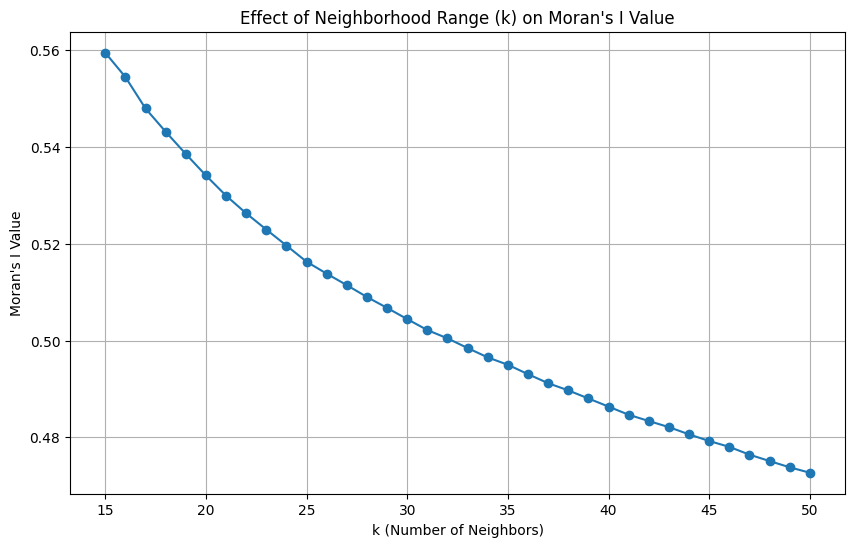

In [7]:
# Define the range of k values you want to test
k_values = range(15, 51)  # testing k from 1 to 50
# Initialize an empty list to store Moran's I value
moran_values = []

# Loop through each k value
for k in k_values:
    # Create the spatial weight matrix for the current k value
    w_adaptive = spatial_weight_matrix(gdf_lvl, k)
    # Calculate Moran's I value
    moran = global_moran_val(gdf_lvl, 'GDP_VALUE', w_adaptive)
    # Append the Moran's I value to the list
    moran_values.append(moran.I)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, moran_values, marker='o')
plt.title("Effect of Neighborhood Range (k) on Moran's I Value")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Moran's I Value")
plt.grid(True)
plt.show()

In [8]:
# Remember to reset index before updating it with lisa values and corresponding significance and quadrant values
gdf_lvl.reset_index(inplace=True)

In [9]:
# Updating the dataframe to include local lisa information
gdf_lvl = lisa_df_update(gdf_lvl, lisa)

### Local Moran's I plots

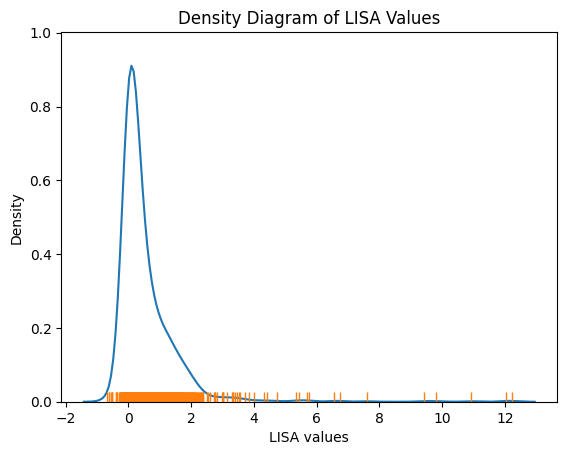

In [10]:
local_moran_density_plot(lisa)

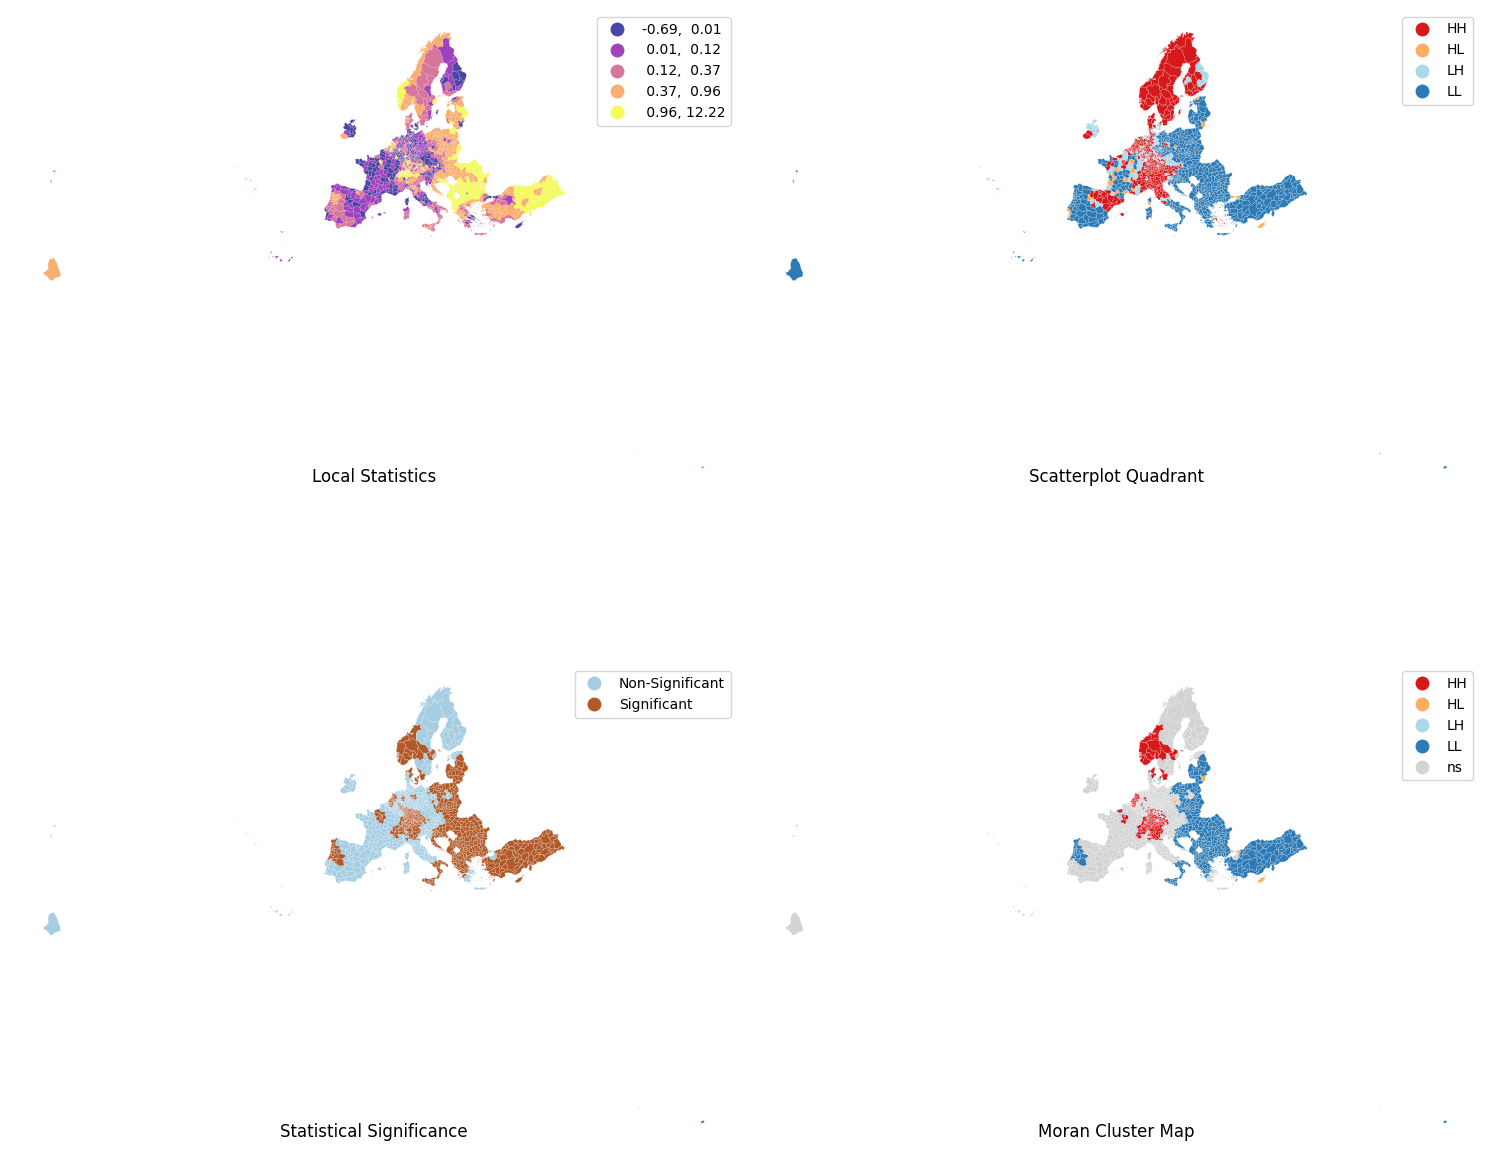

In [11]:
local_moran_plots(gdf_lvl, lisa)

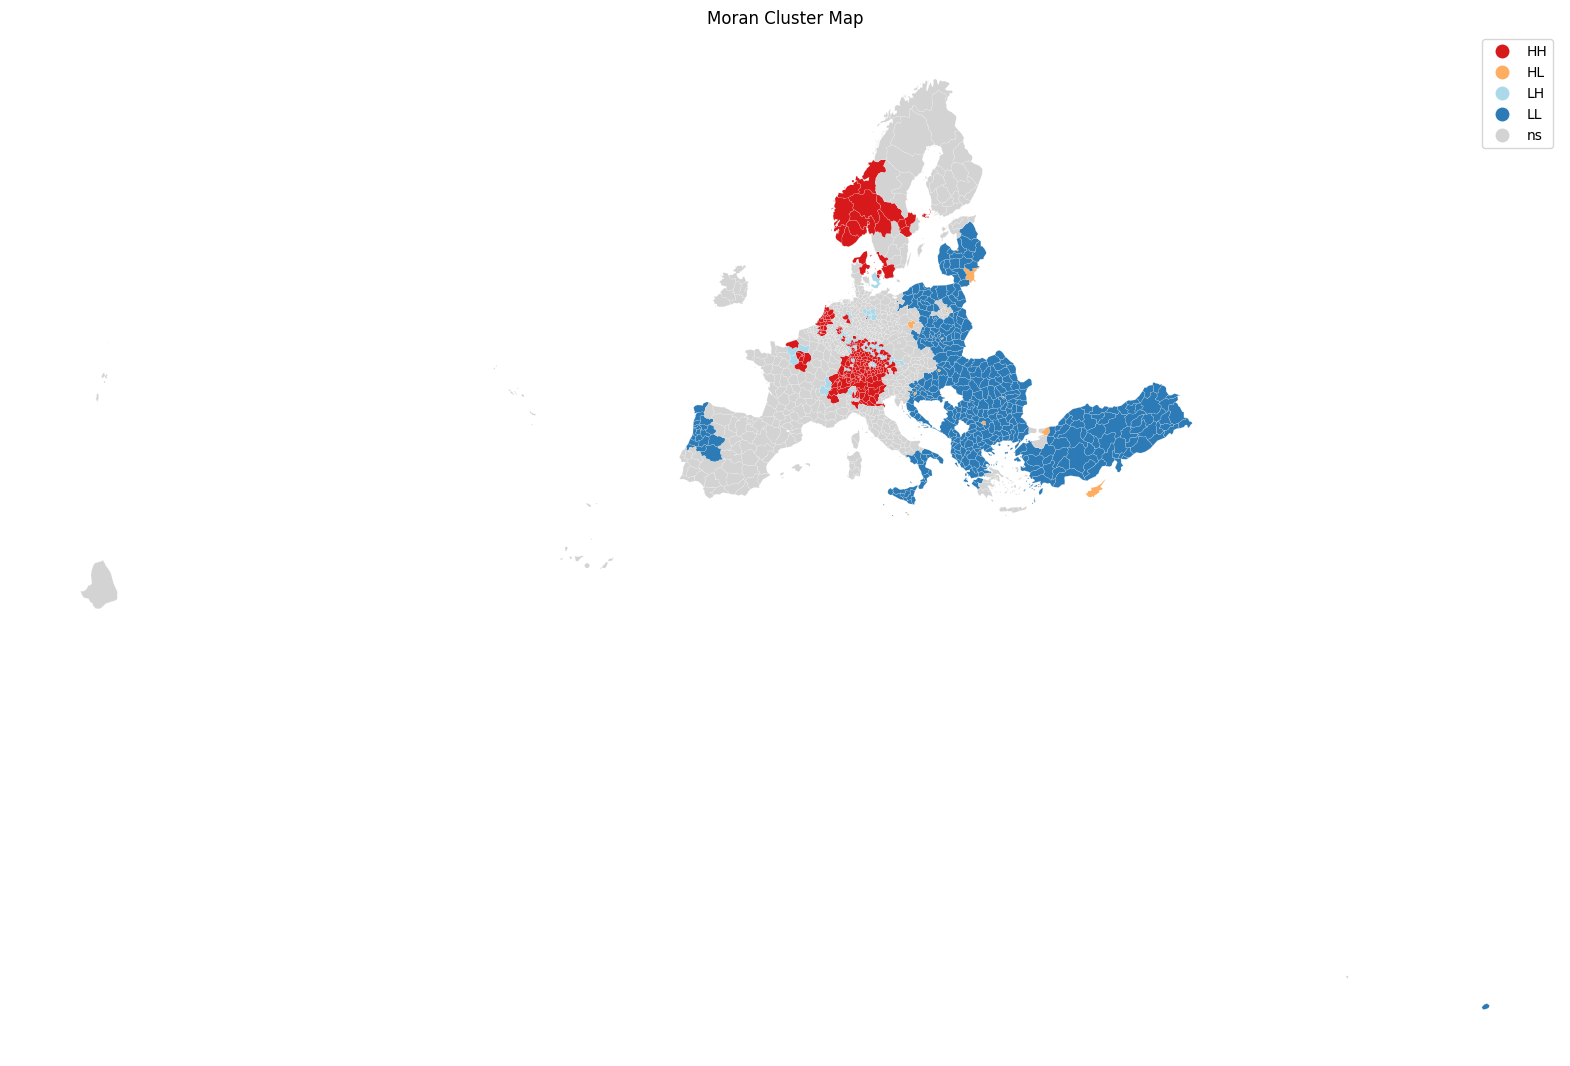

In [12]:
lisa_cluster_map(lisa, gdf_lvl)

# NUTS 2 v.s. NUTS 3 level

In [51]:
# Reading NUTS 2 level dataframe
gdf_lvl_2 = pd.read_csv("results/SAC_local_NUTS2.csv")
gdf_lvl_2 = gdf_lvl_2.drop(columns=['Unnamed: 0'])
original_len = len(gdf_lvl_2)
gdf_lvl_2 = gdf_lvl_2[gdf_lvl_2['LISA_sig']=='Significant']
final_len = len(gdf_lvl_2)
print("Percentage of regions lost at NUTS 2 level after Significance test:")
proportion = (original_len-final_len)/original_len
print(proportion*100)

Percentage of regions lost at NUTS 2 level after Significance test:
35.172413793103445


In [52]:
# Renaming NUTS 3 level dataframe
gdf_lvl_3 = gdf_lvl.copy()
original_len = len(gdf_lvl_3)
gdf_lvl_3 = gdf_lvl_3[gdf_lvl_3['LISA_sig']=='Significant']
final_len = len(gdf_lvl_3)
print("Percentage of regions lost at NUTS 3 level after Significance test:")
proportion = (original_len-final_len)/original_len
print(proportion*100)

Percentage of regions lost at NUTS 3 level after Significance test:
47.50378214826021


## Proportion of HL,HH,LL, and LH values

In [46]:
# Calculating proportion of each quadrant in both dataframes
# Calculate the proportion of each value
value_counts_nuts2 = gdf_lvl_2['LISA_quadrant'].value_counts(normalize=True)
# Convert to dictionary
proportions_nuts2 = {str(key): value for key, value in value_counts_nuts2.items()}
print("NUTS 2 level results:")
proportions_nuts2

NUTS 2 level results:


{'3': 0.4521276595744681,
 '1': 0.44680851063829785,
 '2': 0.05851063829787234,
 '4': 0.0425531914893617}

In [47]:
# Calculate the proportion of each value
value_counts_nuts3 = gdf_lvl_3['LISA_quadrant'].value_counts(normalize=True)
# Convert to dictionary
proportions_nuts3 = {str(key): value for key, value in value_counts_nuts3.items()}
print("NUTS 3 level results:")
proportions_nuts3

NUTS 3 level results:


{'3': 0.5360230547550432,
 '1': 0.3659942363112392,
 '2': 0.07780979827089338,
 '4': 0.020172910662824207}

## Spatial outlier similarity

In [72]:
# Extracting HL regions
gdf_lvl2_HL = gdf_lvl_2[gdf_lvl_2['LISA_quadrant']==4]
gdf_lvl3_HL = gdf_lvl_3[gdf_lvl_3['LISA_quadrant']==4]
gdf_lvl2_HL

,NUTS_ID,NUTS_NAME,NAME_LATN,GDP_VALUE,geometry,centroid_lon,centroid_lat,LISA_VALUE,LISA_sig,LISA_p_values,LISA_quadrant
36,CY00,Κύπρος,Kýpros,24430.434783,POLYGON ((6342668.881999999 1629618.4980999995...,6.426394e+06,1.653576e+06,-0.051325,Significant,0.002,4
89,EL30,Aττική,Attiki,27281.818182,MULTIPOLYGON (((5571753.936000001 1641409.3346...,5.520666e+06,1.742712e+06,-0.155801,Significant,0.016,4
155,HR05,Grad Zagreb,Grad Zagreb,28652.173913,"POLYGON ((4783286.1547 2550595.059800001, 4798...",4.788004e+06,2.540108e+06,-0.165405,Significant,0.033,4
157,HU11,Budapest,Budapest,35290.909091,"POLYGON ((4991721.7037 2752702.183700001, 4991...",5.006074e+06,2.750471e+06,-0.430164,Significant,0.009,4
189,LT01,Sostinės regionas,Sostinės regionas,25856.521739,POLYGON ((5375053.1280000005 3695401.143999999...,5.292073e+06,3.626183e+06,-0.120404,Significant,0.002,4
229,PL91,Warszawski stołeczny,Warszawski stołeczny,35495.652174,POLYGON ((5071981.877599999 3329177.8824000005...,5.077683e+06,3.294919e+06,-0.700539,Significant,0.001,4
243,RO32,Bucureşti-Ilfov,Bucureşti-Ilfov,31817.391304,"POLYGON ((5609779.0754 2494714.0913999993, 559...",5.595717e+06,2.516740e+06,-0.716151,Significant,0.001,4
264,TR10,İstanbul,İstanbul,26015.789474,MULTIPOLYGON (((5940443.759199999 2176264.6207...,5.883264e+06,2.203199e+06,-0.142801,Significant,0.001,4


In [1]:
gdf_lvl3_HL

NameError: name 'gdf_lvl3_HL' is not defined

AT NUTS 2 level, every country identified has only one region within: CY, EL, HR, HU, LT, PL, RO, TR
At NUTS 3 level, minimum country code is BG, CY, HR , HU , LT , LV and MT with only one region identified each. maximum country code is PL (5 regions identified)
So an interesting observation is that at the NUTS 3 level, 5 sub-regions in PL (Poland) are identified as significant compared to only one sub-region at the NUTS 2 level.

In [73]:
# Extracting LH regions
gdf_lvl2_LH = gdf_lvl_2[gdf_lvl_2['LISA_quadrant'] == 2]
gdf_lvl3_LH = gdf_lvl_3[gdf_lvl_3['LISA_quadrant'] == 2]
gdf_lvl2_LH

,NUTS_ID,NUTS_NAME,NAME_LATN,GDP_VALUE,geometry,centroid_lon,centroid_lat,LISA_VALUE,LISA_sig,LISA_p_values,LISA_quadrant
19,BE32,Prov. Hainaut,Prov. Hainaut,20345.000000,MULTIPOLYGON (((3860314.060799999 3093300.2357...,3.893740e+06,3.057433e+06,-0.201465,Significant,0.007,2
20,BE33,Prov. Liège,Prov. Liège,23035.000000,"POLYGON ((4016501.8027 3080744.5735, 4025883.6...",4.018870e+06,3.053845e+06,-0.043447,Significant,0.006,2
21,BE34,Prov. Luxembourg (BE),Prov. Luxembourg (BE),20121.052632,"POLYGON ((4013536.1161 3037570.4153000005, 401...",3.999530e+06,2.992225e+06,-0.257553,Significant,0.005,2
22,BE35,Prov. Namur,Prov. Namur,21860.000000,POLYGON ((3993546.6038000006 3039999.524900000...,3.954402e+06,3.027894e+06,-0.128091,Significant,0.004,2
66,DE93,Lüneburg,Lüneburg,21647.826087,"POLYGON ((4256375.465500001 3414615.2423, 4273...",4.306822e+06,3.341909e+06,-0.155338,Significant,0.004,2
84,DK02,Sjælland,Sjælland,22865.217391,"POLYGON ((4433591.1709 3618811.190199999, 4438...",4.430666e+06,3.573631e+06,-0.045788,Significant,0.024,2
129,FRC2,Franche-Comté,Franche-Comté,21759.090909,"POLYGON ((4083043.8422 2749494.0096000005, 408...",4.024355e+06,2.684973e+06,-0.176677,Significant,0.001,2
132,FRE1,Nord-Pas de Calais,Nord-Pas de Calais,22473.913043,POLYGON ((3817784.9420999996 3090853.984999999...,3.806515e+06,3.064804e+06,-0.058397,Significant,0.030,2
133,FRE2,Picardie,Picardie,21081.818182,"POLYGON ((3826941.7205 3016775.3191, 3832402.4...",3.802587e+06,2.973156e+06,-0.109724,Significant,0.026,2
136,FRF3,Lorraine,Lorraine,21072.727273,"POLYGON ((3988312.6208999995 2955361.1799, 399...",4.037699e+06,2.857248e+06,-0.131570,Significant,0.018,2


For significant Low-High regions, an interesting observation is that at the NUTS 2 level, only one region within Denmark (country code: DE) was identified however, at the NUTS 3 level, 15 sub-regions are identified.
At the NUTS 2 level, Belgium has the highest number of LH regions at 5.